In [3]:
%load_ext autoreload
%autoreload 2
import warnings
from datetime import timedelta

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import circmean

from ocr import catalog
from ocr.config import OCRConfig
from ocr.conus404 import (
    # build_fire_weather_mask,
    # compute_modal_wind_direction,
    compute_wind_speed_and_direction,
    geo_sel,
    load_conus404,
    rotate_winds_to_earth,
)
from ocr.utils import bbox_tuple_from_xarray_extent

warnings.filterwarnings('ignore', category=UserWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
config = OCRConfig(storage_root='/tmp/era5-vs-conus404')
config

OCRConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/era5-vs-conus404', vector=VectorConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/era5-vs-conus404', prefix='intermediate/fire-risk/vector/qa', output_prefix='output/fire-risk/vector/qa', debug=False), icechunk=IcechunkConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/era5-vs-conus404', prefix='output/fire-risk/tensor/qa/ocr.icechunk', debug=False), chunking=<POLYGON ((-64.054 22.428, -64.054 52.482, -128.387 52.482, -128.387 22.428,...>, coiled=CoiledConfig(tag={'Project': 'OCR'}, forward_aws_credentials=False, spot_policy='spot_with_fallback', region='us-west-2', ntasks=1, vm_type='m8g.2xlarge', scheduler_vm_type='m8g.2xlarge'), debug=False)

In [ ]:
def intify(arr):
    return int(arr)

In [ ]:
setups = {'CP': '', 'WFC': ''}

In [ ]:
buildings_dict = {}
for key, ds in setups.items():
    # bbox = [-120.69, 47.57, -120.61, 47.61] # leavenworth
    bbox = bbox_tuple_from_xarray_extent(
        ds, x_name='longitude', y_name='latitude'
    )  # why does this crash?
    building_parquet = catalog.get_dataset('conus-overture-buildings')
    buildings_table = building_parquet.query_geoparquet(
        """SELECT bbox, ST_AsText(geometry) as geometry
        FROM read_parquet('{s3_path}')"""
        + f"""
        WHERE
        bbox.xmin BETWEEN {bbox[0]} AND {bbox[2]} AND
        bbox.ymin BETWEEN {bbox[1]} AND {bbox[3]}"""
    ).df()
    # buildings_table['geometry'] = gpd.GeoSeries.from_wkt(buildings_table['geometry'])
    # buildings_dict[key] = gpd.GeoDataFrame(buildings_table, geometry='geometry', crs='EPSG:4326')
    # data_var_list = list(ds.data_vars)
    # for var in data_var_list:
    #     buildings_dict[key][var] = extract_points(buildings_dict[key], ds[var])

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

# Questions
- need to be able to extract lots of buildings without it crashing! how do i overcome that?
- modify the red flag threshold to fill in the map - a way to inspect that
- how to access wind data from conus 404 using lat/lon coords
- How do we know whether it’s updated in the webmap? Is there a way to check?
- net value change - relative risk

In [ ]:
# For a handful of historic fires, were the winds during those events the same as the ones we predict with the mode?

In [23]:
(buildings_dict['wind']['wind_risk_2011'] - buildings_dict['all_circles']['USFS_RPS'])

np.float32(52.285175)

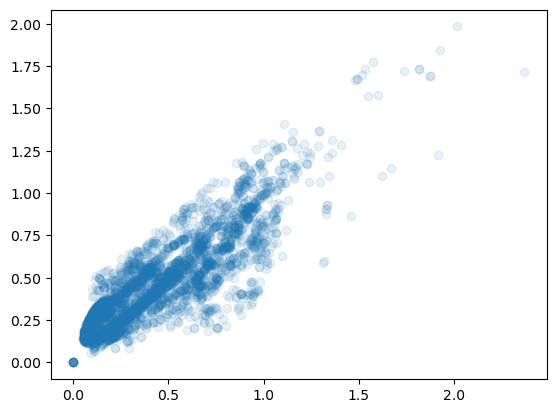

In [26]:
plt.scatter(
    buildings_dict['all_circles']['USFS_RPS'].values,
    buildings_dict['wind']['wind_risk_2011'].values,
    alpha=0.1,
)

In [ ]:
# plot distributions next to eachother to see how different it is

In [36]:
bbox = [-125, 49, -110, 25]  # western us

catalog.get_dataset('alexandre-2016-digitized-buildings')

Dataset(name='alexandre-2016-digitized-buildings', description='Data from: Factors related to building loss due to wildfires in the conterminous United States', bucket='carbonplan-ocr', prefix='input/fire-risk/vector/alexandre-2016/digitized_buildings_2000_2010.parquet', data_format='geoparquet', version='v1', license=None)

# Where was the wind coming from during historic fires and did we get it right?

In [ ]:
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 25)

In [305]:
# incidents
df = pd.read_csv('s3://carbonplan-risks/structures/ics209-plus-wf_incidents_1999to2020.csv')

/var/folders/q4/3p8rs8s17q13wbkj0y58w6hm0000gn/T/ipykernel_46547/1726762472.py:2: DtypeWarning: Columns (7,13,16,17,18,19,20,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('s3://carbonplan-risks/structures/ics209-plus-wf_incidents_1999to2020.csv')


In [306]:
# remove alaska
df = df[~(df['POO_STATE'] == 'AK')]

In [307]:
# grab any fire that destroyed any structures
df = df[df['STR_DESTROYED_TOTAL'] > 10]  # STR_THREATENED_MAX, STR_DAMAGED_TOTAL
# grab relevant data
# df = df[['INCIDENT_NAME', 'DISCOVERY_DATE','POO_LATITUDE','POO_LONGITUDE', 'STR_DAMAGED_TOTAL']]

In [175]:
# df[['POO_LATITUDE','POO_LONGITUDE', 'LRGST_FOD_COORDS', 'LRGST_FOD_LONGITUDE', 'LRGST_FOD_LONGITUDE']]

In [261]:
ds = load_conus404(add_spatial_constants=True)

In [262]:
df['incident_wind_from_dir'] = np.nan
df['fire_weather_wind_mode'] = np.nan
df['incident_windspeed'] = np.nan

In [263]:
wind_distrib_ds = (
    catalog.get_dataset('conus404-ffwi-p99-wind-direction-distribution').to_xarray().load()
)

In [264]:
wind_distrib_ds.crs.attrs['crs_wkt'] = ds.crs.attrs['crs_wkt']

In [308]:
def calc_direction_code(direction_degrees):
    shifted_direction = (direction_degrees + 22.5) % 360
    direction_code = np.floor(shifted_direction / 45)
    return direction_code

In [ ]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.POO_LONGITUDE, df.POO_LATITUDE), crs='EPSG:4326'
)

In [682]:
df = df.loc[gdf.cx[-130:-60, 20:52].index]

In [683]:
wind_from_dirs = []
wind_speeds = []
wind_distribs = []
# iterate through each set of points and grab the mode value that is nearest in the mode calculated map
for i, (index, row) in enumerate(df.iterrows()):
    latitude = row['POO_LATITUDE']
    longitude = row['POO_LONGITUDE']
    wind_mode = (
        catalog.get_dataset('conus404-ffwi-p99-mode-reprojected')
        .to_xarray()
        .wind_direction_mode.sel(latitude=latitude, longitude=longitude, method='nearest')
        .load()
    )
    wind_distrib_pixel = geo_sel(
        wind_distrib_ds, lon=float(longitude), lat=float(latitude)
    ).wind_direction_distribution.values
    incident_ds = geo_sel(ds, lon=float(longitude), lat=float(latitude))
    earth_u, earth_v = rotate_winds_to_earth(incident_ds)
    wind_ds = compute_wind_speed_and_direction(earth_u, earth_v)
    # go to the conus404 dataset and grab the point that is nearest and find the wind around the discovery date
    # date_types = ['DISCOVERY_DATE', 'WF_MAX_GROWTH_DATE']#, 'WF_PEAK_AERIAL_DATE', 'WF_PEAK_PERSONNEL_DATE']
    date_type = 'WF_MAX_GROWTH_DATE'
    df.loc[index, 'fire_weather_wind_mode'] = wind_mode.values
    # for date_type in date_types:
    print(date_type)
    date = row[date_type]
    incident_wind_fromdir = wind_ds.sel(
        time=slice(
            pd.to_datetime(date) - timedelta(hours=12), pd.to_datetime(date) + timedelta(hours=12)
        )
    ).sfcWindfromdir.values
    incident_windspeeds = wind_ds.sel(
        time=slice(
            pd.to_datetime(date) - timedelta(hours=12), pd.to_datetime(date) + timedelta(hours=12)
        )
    ).sfcWind.values
    # wind_from_dirs.append(incident_wind_fromdir)
    # wind_speeds.append(incident_windspeeds)
    # upper_threshold = np.quantile(
    df.loc[index, f'ICS_wind_from_dir_{date_type}'] = calc_direction_code(
        np.rad2deg(circmean(np.deg2rad(incident_wind_fromdir)))
    )
    df.loc[index, f'ICS_windspeed_{date_type}'] = incident_windspeeds.mean()
    df.loc[index, f'ICS_dir_match_mode_{date_type}'] = (
        calc_direction_code(np.rad2deg(circmean(np.deg2rad(incident_wind_fromdir)))) == wind_mode
    ).values
    wind_distribs.append(wind_distrib_pixel)
    for wind_index, weight in enumerate(wind_distrib_pixel):
        df.loc[index, f'FWI_fract_{wind_index}_{date_type}'] = weight

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620


In [ ]:
df_wind_from_dirs = pd.DataFrame(wind_from_dirs, index=df.iloc[0:228].index)
df_wind_speeds = pd.DataFrame(wind_speeds, index=df.iloc[0:228].index)
df_wind_distribs = pd.DataFrame(wind_distribs, index=df.index)

In [534]:
# THIS IS THE DF WE CAN USE! 9/18
# df.to_csv('s3://carbonplan-ocr/evaluation/ICS_fires_FFWI_10structures.csv') # this only has ~200 rows - includes date of max growth - fires that destroyed > 50 structures

In [180]:
# df.to_csv('s3://carbonplan-ocr/evaluation/ICS_fires_FFWI_wind_directions_detailed.csv') # this only has ~200 rows - includes date of max growth - fires that destroyed > 50 structures
# df.to_csv('s3://carbonplan-ocr/evaluation/ICS_fires_wind_directions.csv') # this is a long one based on discovery date and all fires that destroyed one or more structures

In [336]:
def get_values(ds):
    return ds.values

In [684]:
matches = (
    pd.DataFrame(df['ICS_dir_match_mode_WF_MAX_GROWTH_DATE'].apply(intify))
    .rename({'ICS_dir_match_mode_WF_MAX_GROWTH_DATE': 0}, axis=1)
    .astype(bool)
)
fails = ~matches

In [596]:
gdf['ICS_dir_match_mode_WF_MAX_GROWTH_DATE'] = gdf['ICS_dir_match_mode_WF_MAX_GROWTH_DATE'].astype(
    'int'
)

In [614]:
states = gpd.read_file('/Users/orianachegwidden/Downloads/cb_2018_us_state_20m.zip')

In [615]:
states = states[~(states['STUSPS'].isin(['AK', 'PR', 'HI']))]

In [667]:
def plot_wind_distrib(distrib_to_plot):
    import matplotlib.pyplot as plt
    import numpy as np

    # Compute pie slices
    N = 8
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    radii = distrib_to_plot  # fill in the distribution here 10 * np.random.rand(N)
    width = np.pi / 8  # * np.random.rand(N)

    ax = plt.subplot(111, projection='polar')
    bars = ax.bar(theta, radii, width=width, bottom=0.0)
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2.0)
    # Use custom colors and opacity
    for r, bar in zip(radii, bars):
        bar.set_facecolor(plt.cm.viridis(r / 10.0))
        bar.set_alpha(0.5)

    return

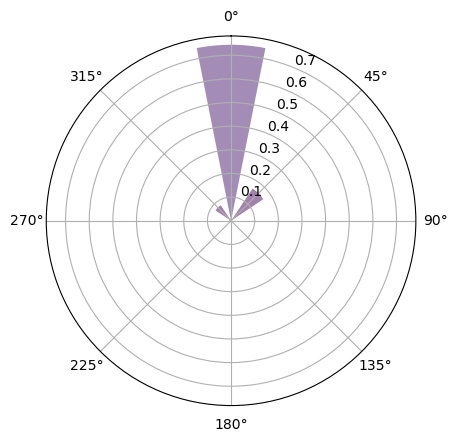

In [668]:
plot_wind_distrib(df_wind_distribs.loc[34522].values)  # 34522 34524

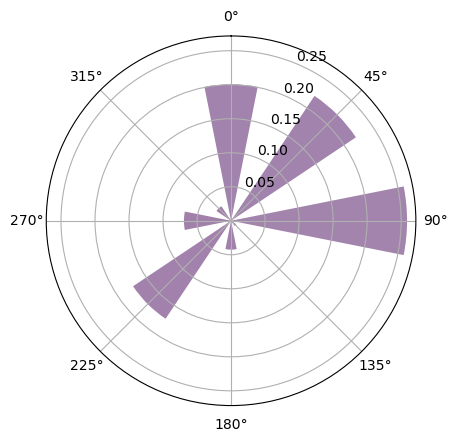

In [669]:
plot_wind_distrib(df_wind_distribs.loc[34524].values)

<Axes: >

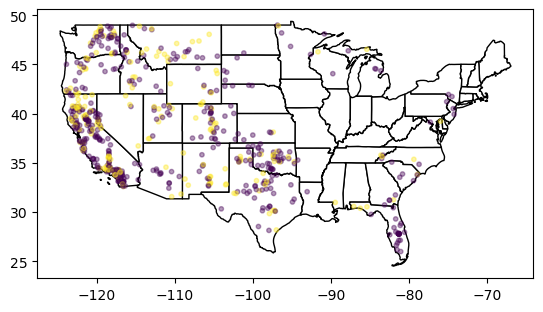

In [676]:
fig, axarr = plt.subplots()
states.plot(ax=axarr, color='white', edgecolor='black')
gdf.cx[-130:-60, 20:52].plot(
    ax=axarr, column='ICS_dir_match_mode_WF_MAX_GROWTH_DATE', markersize=10, alpha=0.4
)

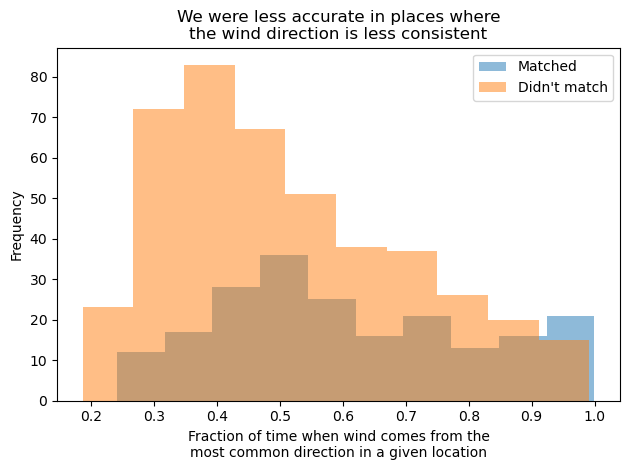

In [685]:
fig, axarr = plt.subplots()
blues = pd.DataFrame(df_wind_distribs.max(axis=1))[matches][0].plot(
    ax=axarr, kind='hist', alpha=0.5, label='Matched', legend=True
)
oranges = pd.DataFrame(df_wind_distribs.max(axis=1))[fails][0].plot(
    ax=axarr, kind='hist', alpha=0.5, label="Didn't match", legend=True
)
axarr.set_xlabel(
    'Fraction of time when wind comes from the\nmost common direction in a given location'
)
plt.title('We were less accurate in places where\nthe wind direction is less consistent')
plt.tight_layout()
plt.savefig('fire_incidents_match_mode.png')
# plt.legend(handles=[blues, oranges])

In [688]:
matches.sum() / len(matches)

0    0.321821
dtype: float64

<Axes: ylabel='Frequency'>

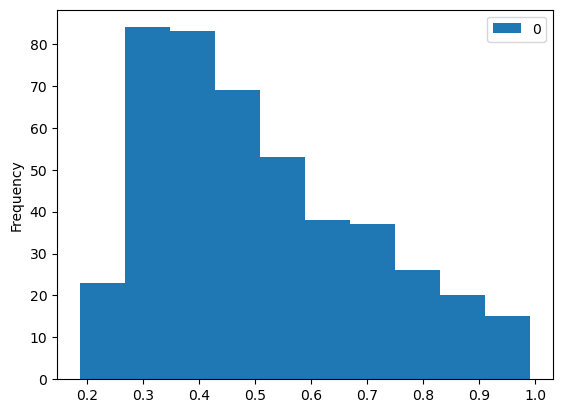

<Axes: ylabel='Frequency'>

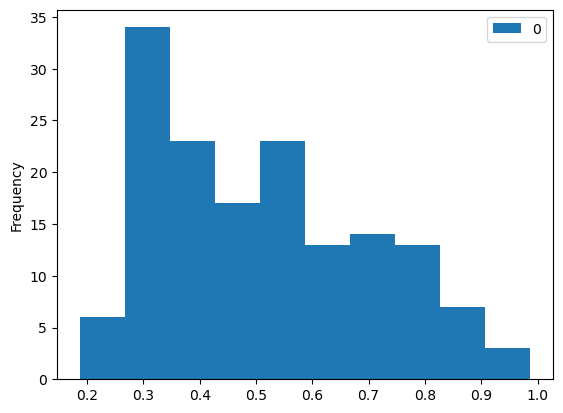

In [402]:
pd.DataFrame(df_wind_distribs.max(axis=1))[fails].plot(kind='hist')

In [210]:
discovery = df['ICS_dir_match_mode_DISCOVERY_DATE'].apply(intify)
growth = df['ICS_dir_match_mode_WF_MAX_GROWTH_DATE'].apply(intify)

In [61]:
df = pd.read_csv('s3://carbonplan-ocr/evaluation/ICS_fires_FFWI_wind_directions_detailed.csv')

In [118]:
df = df[~df['fire_weather_wind_mode'].isna()]

In [63]:
# in how many situations did we predict the wind was coming from the same direction

In [64]:
(df['wind_from_dir_code'] == df['fire_weather_wind_mode']).sum() / len(df)

np.float64(0.4117647058823529)

In [119]:
df['match'] = df['wind_from_dir_code'] == df['fire_weather_wind_mode']

In [31]:
df = pd.read_csv('s3://carbonplan-ocr/evaluation/ICS_fires_wind_directions.csv')